In [1]:
import os
import string

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

NAMES_FILE_PATH = os.path.join(os.getcwd(), 'src', 'names.txt')
ALPHABETIC_LATTERS = string.ascii_letters[:26]

In [2]:
with open(NAMES_FILE_PATH) as f:
    words = f.read().split('\n')
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
letter_to_number = {letter: number  for  number, letter in  enumerate(ALPHABETIC_LATTERS, 1)}
letter_to_number['<>'] = 0
number_to_letter = {number: letter for letter, number  in  letter_to_number.items()}

In [4]:
words_bigrams = torch.zeros((27, 27), dtype=torch.int32)

for word in words:
    extended_word = ['<>']  + list(word) + ['<>']
    for right_character_idx in range(1, len(extended_word)):
        left_character_idx = right_character_idx - 1
        left_character_position, right_character_position = letter_to_number[extended_word[left_character_idx]], letter_to_number[extended_word[right_character_idx]]
        words_bigrams[left_character_position, right_character_position] += 1

In [5]:
words_bigrams_probs = words_bigrams.float()
words_bigrams_probs /= words_bigrams_probs.sum(1, keepdim=True)

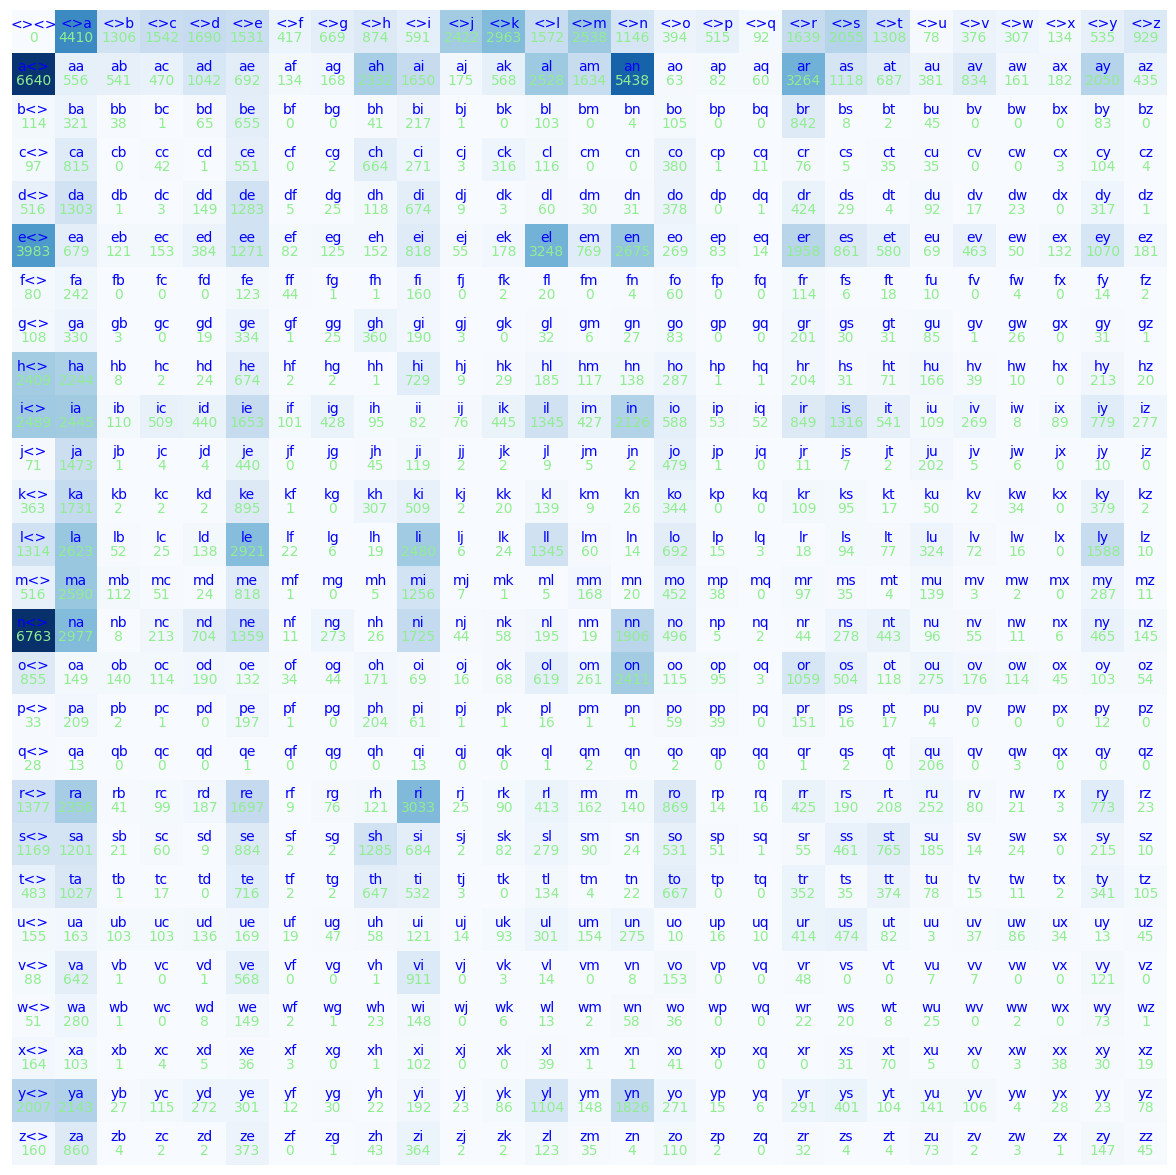

In [6]:
plt.figure(figsize=(15, 15))
plt.imshow(words_bigrams, cmap='Blues')
for left_character_idx in range(27):
    for right_character_idx in range(27):
        plt.text(right_character_idx, left_character_idx, f'{number_to_letter[left_character_idx]}{number_to_letter[right_character_idx]}', ha='center',va='bottom',color='blue')
        plt.text(right_character_idx, left_character_idx, words_bigrams[left_character_idx, right_character_idx].item(), ha='center', va='top', color='lightgreen')
plt.axis('off')
plt.show()

In [7]:
def generate(k=1):
    generated_words = []
    for _ in range(k):
        character_idx = 0
        generated_word = []
        while True:
            character_bigram_prob_distribution = words_bigrams_probs[character_idx]
            character_idx = torch.multinomial(character_bigram_prob_distribution, 1, replacement=True).item()
            generated_word.append(number_to_letter[character_idx])
            if character_idx == 0:
                break
        generated_word.pop()
        generated_words.append(''.join(generated_word))
    return generated_words
    
generate(10)

['ve',
 'gyale',
 'ielay',
 'drame',
 'data',
 'jon',
 'nyebierch',
 'rianney',
 'mah',
 'k']

In [8]:
char_to_int = {char: i for i, char in enumerate(string.ascii_letters[:26], 1)}
char_to_int['<>'] = 0
int_to_char = {i: char for char, i in char_to_int.items()}

In [9]:
class BigramLanguageModel:
    char_to_int = char_to_int
    int_to_char = int_to_char

    def __init__(self, learning_rate: float = 0.1, n_iters: int = 10):
        self._w1 = torch.randn((27, 2), requires_grad=True)
        self._w2 = torch.randn((2, 27), requires_grad=True)
        self.learning_rate = learning_rate
        self.n_iters = n_iters

    def __repr__(self) -> str:
        return f'BigramLanguageModel()'

    def _build_train_data(self, words: list[str]) -> tuple[torch.Tensor, torch.Tensor]:
        xs, ys  = [], []
        for word in words:
            word = ['<>'] + list(word) + ['<>']
            for ch1, ch2 in zip(word, word[1:]):
                xs.append(self._onehot(self.char_to_int[ch1])); ys.append(self.char_to_int[ch2])
        return torch.vstack(xs), torch.tensor(ys)
    
    @staticmethod
    def _onehot(val: torch.Tensor) -> torch.Tensor:
        val = torch.tensor(val) if not isinstance(val, torch.Tensor) else  val
        return F.one_hot(val, num_classes=27).float().view(1, -1)
    
    @staticmethod
    def _softmax(val: torch.Tensor) -> torch.Tensor:
        val = val.exp()
        return val / val.sum(1, keepdim=True)
    
    def _forward(self, X: torch.Tensor):
        return self._softmax((X @ self._w1) @ self._w2)
    
    @staticmethod
    def  _negative_log_likelihood(y_true, y_pred) -> torch.Tensor:
        return -y_pred[torch.arange(y_pred.shape[0]), y_true].log().mean()
    
    def _step(self, loss: torch.Tensor) -> None:
        self._w1.grad, self._w2.grad = None, None
        loss.backward()
        self._w1.data -= self.learning_rate * self._w1.grad
        self._w2.data -= self.learning_rate * self._w2.grad

    def fit(self, words: list[str], verbose: bool = True) -> None:
        xs, ys = self._build_train_data(words)
        for iteration in range(self.n_iters):
            pred = self._forward(xs)
            loss = self._negative_log_likelihood(ys, pred)
            if verbose and iteration %  100 == 0: 
                print(f'Loss {iteration}:', loss.item())
            self._step(loss)

    def generate(self, k:int = 5, max_len: int = 100) -> list[str]:
        generated_words = []
        for _ in range(k):
            generated_word, current_len, current_idx = [], 0, 0
            while True and current_len < max_len:
                next_char_prob_distr = self._forward(self._onehot(current_idx))
                current_idx = torch.multinomial(next_char_prob_distr, 1, replacement=True).item()
                generated_word.append(self.int_to_char[current_idx])
                if current_idx == 0: break
            if generated_word: generated_word.pop()
            generated_words.append(''.join(generated_word))
        return generated_words

In [10]:
model = BigramLanguageModel(n_iters=3000, learning_rate=2)
model.fit(words)

Loss 0: 4.22087287902832
Loss 100: 2.6508169174194336
Loss 200: 2.626840114593506
Loss 300: 2.6220762729644775
Loss 400: 2.6203620433807373
Loss 500: 2.619462728500366
Loss 600: 2.6189024448394775
Loss 700: 2.6185247898101807
Loss 800: 2.6182572841644287
Loss 900: 2.6180596351623535
Loss 1000: 2.6179075241088867
Loss 1100: 2.617786169052124
Loss 1200: 2.6176865100860596
Loss 1300: 2.617602825164795
Loss 1400: 2.617530584335327
Loss 1500: 2.617467164993286
Loss 1600: 2.6174111366271973
Loss 1700: 2.6173603534698486
Loss 1800: 2.617314577102661
Loss 1900: 2.6172730922698975
Loss 2000: 2.617234468460083
Loss 2100: 2.617199182510376
Loss 2200: 2.617166519165039
Loss 2300: 2.617136001586914
Loss 2400: 2.61710786819458
Loss 2500: 2.617081642150879
Loss 2600: 2.6170568466186523
Loss 2700: 2.6170339584350586
Loss 2800: 2.6170122623443604
Loss 2900: 2.6169919967651367


In [11]:
model.generate(15)

['irilaae',
 'vekare',
 'zi',
 'i',
 '',
 '',
 'kona',
 'dob',
 'doraana',
 'k',
 'ftaliio',
 'female',
 'yn',
 'ssa',
 '']